In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as trf
import torchvision

In [2]:
%matplotlib inline

In [3]:
torch.cuda.torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
cuda0 = torch.device('cuda:0')

In [5]:
train = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                          download=True,
                                          transform=trf.ToTensor())
test = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                         download=True,
                                         transform=trf.ToTensor())

In [6]:
b_size = 42

In [7]:
train_loader = torch.utils.data.DataLoader(train, batch_size=b_size,
                                           shuffle=True)

In [8]:
test_loader = torch.utils.data.DataLoader(test, batch_size=b_size,
                                          shuffle=False)

In [9]:
def show_batch_example_from_loader(data_loader):
    train_iterable = iter(data_loader)
    data, labels = train_iterable.next()
    fig = plt.figure(figsize=(14, 8))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, img in enumerate(data):
        ax = fig.add_subplot(6, 7, i + 1)
        ax.imshow(data[i].numpy().reshape(28, 28))

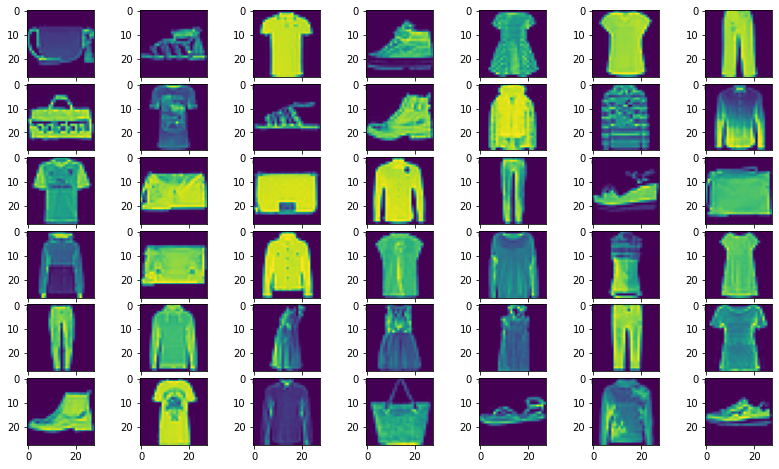

In [10]:
show_batch_example_from_loader(train_loader)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(24 * 24 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # Bx1x28x28 => Bx16x26x26
        x = self.conv1(x)
        x = F.relu(F.dropout2d(x))
        
        # Bx16x26x26 => Bx32x24x24
        x = self.conv2(x)
        x = F.relu(F.dropout2d(x))

        # flatten => Bx(32*24*24)
        x = x.flatten(start_dim = 1)

        # Bx(32*24*24) => Bx128
        x = self.d1(x)
        x = F.relu(F.dropout(x))

        # 32x128 => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [12]:
class train_test_net:
    def __init__(self, net, optimizer, batch_size, criterion, metric, device):
        self.net = net
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.criterion = criterion
        self.metric = metric
        self.device = device
        self.net = self.net.to(device)
    
    def train(self, train_loader, num_epochs=10, verbose=True, val_loader=None):
        for epoch in range(num_epochs):
            train_loss = 0.0
            train_acc = 0.0
            if val_loader:
                val_acc = 0.0
            self.net = self.net.train()

            for i, (images, labels) in enumerate(train_loader):
                
                images = images.to(self.device)
                labels = labels.to(self.device)

                logits = self.net(images)
                loss = self.criterion(logits, labels)
                self.optimizer.zero_grad()
                loss.backward()

                self.optimizer.step()
                if verbose:
                    train_loss += loss.detach().item()
                    train_acc += self.metric(logits, labels, self.batch_size)
            
            num_batches_train = i
            self.net.eval()
            
            if val_loader:
                for i, (val_images, val_labels) in enumerate(val_loader):
                    val_images = val_images.to(self.device)
                    val_labels = val_labels.to(self.device)
                    val_logits = self.net(val_images)
                    val_acc += self.metric(val_logits, 
                                           val_labels, 
                                           self.batch_size)
                num_val_batches = i

            if verbose:
                if val_loader:
                    print("Epoch: %d | Loss: %.4f | "
                          %(epoch, train_loss / num_batches_train) + \
                          "Train Accuracy: %.2f | Validation accuracy %.2f" \
                          %(train_acc / num_batches_train,
                            val_acc / num_val_batches)
                          )
                else:
                    print("Epoch: %d | Loss: %.4f | "
                          %(epoch, train_loss / num_batches_train) + \
                          "Train Accuracy: %.2f" \
                          %(train_acc / num_batches_train)
                          )
        
    def test(self, test_loader):
        test_acc = 0.0
        for i, (images, labels) in enumerate(test_loader, 0):
            images = images.to(self.device)
            labels = labels.to(self.device)
            outputs = self.net(images)
            test_acc += self.metric(outputs, labels, self.batch_size)
        return test_acc / i

In [13]:
def get_accuracy(logit, target, batch_size):
    corrects = (
        torch.max(logit, 1)[1].view(target.size()).data == target.data
        ).sum()
    accuracy = 100.0 * corrects / batch_size
    return accuracy.item()

In [14]:
device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")
mynet = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mynet.parameters(), lr=0.001)

In [15]:
train_test_model = train_test_net(
    mynet,
    optimizer,
    b_size,
    criterion,
    get_accuracy,
    device)

In [16]:
train_test_model.train(train_loader, num_epochs=20, val_loader=test_loader)

Epoch: 0 | Loss: 1.7908 | Train Accuracy: 67.11 | Validation accuracy 74.37
Epoch: 1 | Loss: 1.7008 | Train Accuracy: 76.19 | Validation accuracy 75.81
Epoch: 2 | Loss: 1.6852 | Train Accuracy: 77.71 | Validation accuracy 77.91
Epoch: 3 | Loss: 1.6679 | Train Accuracy: 79.40 | Validation accuracy 79.76
Epoch: 4 | Loss: 1.6582 | Train Accuracy: 80.42 | Validation accuracy 79.99
Epoch: 5 | Loss: 1.6524 | Train Accuracy: 80.97 | Validation accuracy 80.15
Epoch: 6 | Loss: 1.6496 | Train Accuracy: 81.27 | Validation accuracy 80.92
Epoch: 7 | Loss: 1.6492 | Train Accuracy: 81.28 | Validation accuracy 79.66
Epoch: 8 | Loss: 1.6452 | Train Accuracy: 81.69 | Validation accuracy 80.35
Epoch: 9 | Loss: 1.6436 | Train Accuracy: 81.86 | Validation accuracy 80.58
Epoch: 10 | Loss: 1.6430 | Train Accuracy: 81.93 | Validation accuracy 80.69
Epoch: 11 | Loss: 1.6474 | Train Accuracy: 81.49 | Validation accuracy 79.45
Epoch: 12 | Loss: 1.6416 | Train Accuracy: 82.07 | Validation accuracy 81.14
Epoch: 13